In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="cpu"'
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job, to_generation, compute_sample_objectness, resize_set
from IPython.display import Image, display
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import pandas as pd
import h5py
import cv2

from skimage.transform import resize

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from joblib.parallel import delayed, Parallel


def disp_pred(pred, h=20, w=100, y0=25):
    nb_classes = len(pred)
    img = np.zeros((nb_classes * h, w, 3))
    cv2.rectangle(img,(0,0),(img.shape[1],img.shape[0]),(0.3,0.3,0.3),3)
    pad = 0
    col = [[0, 0, 1]] * nb_classes
    for i in range(nb_classes):
        p = int(w * pred[i])
        img[i*(h+pad):i*(h+pad)+h, 0:p, :] = col[i]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(nb_classes):
        cv2.putText(img,str(i),(10,y0+h*i), font, 0.9,(1,1,1),1,cv2.LINE_AA)
        cv2.rectangle(img,(0, i*(h+pad)),(w, i*(h+pad)+h),(0.3,0.3,0.3),2)

    return img

def disp_grid_with_pred(img, preds):
    img = resize_set(img, 100, 100)
    img_ = np.zeros((img.shape[0], 3, img.shape[2]*2, img.shape[3]*2))
    img_[:, :, 0:img.shape[2], 0:img.shape[3]] = img[:, :, :, :]
    for i, pr in enumerate(preds):
        text= disp_pred(pr, h=30, w=200)
        text = resize(text, (img.shape[2], img.shape[3]))
        text = text.transpose((2, 0, 1))
        img_[i, :, 0:img.shape[2], img.shape[3]:] = text
    img_ = disp_grid(img_)
    return img_


/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset83')
S = [j['summary'] for j in jobs]
stats = {s: pd.read_csv('../jobs/results/{}/csv/stats.csv'.format(s)) for s in S}

KeyboardInterrupt: 

In [ ]:
jobs_gen = to_generation(jobs)

In [3]:
model_folder = '../tools/models/external/mnist_classifier'
arch = (open(os.path.join(model_folder, 'model.json'))).read()
model = model_from_json(arch)
model.load_weights(os.path.join(model_folder, 'model.pkl'))

## checking all generated

In [13]:
def load_data():
    from datakit.mnist import load
    data = load(which='train')
    X, y = data['train']['X'], data['train']['y']
    X =  X / 255.
    nb_classes = 10
    X = X[:, None, :, :]
    #X = X[y!=5]
    #y = y[y!=5]
    return X, y, nb_classes
Xreal, yreal, _ = load_data()
X = Xreal[yreal!=5]

In [20]:
X = joblib.load('../../external/dcgan_code/mnist/models/uncond_dcgan/200_gen.npz')

In [ ]:
d = np.load('../exported_data/datasets/12457_vs_fake_jobset76.npz')
y = d['y']
data = d['X']
data = data[:] # test data
y = y[:] # test data
data = data / 255.
X = data[y==10]

In [5]:
batch_size = 1024
preds = []
for i in range(0, len(X), batch_size):
    preds.append(model.predict(X[i:i+batch_size]))
preds = np.concatenate(preds, axis=0)

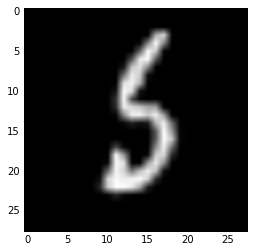

In [6]:
plt.imshow(X[72429,0], cmap='gray')

(0.0, 1.0, (128000, 10))
[72429 93138  9795 ..., 77905 77906     0]


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


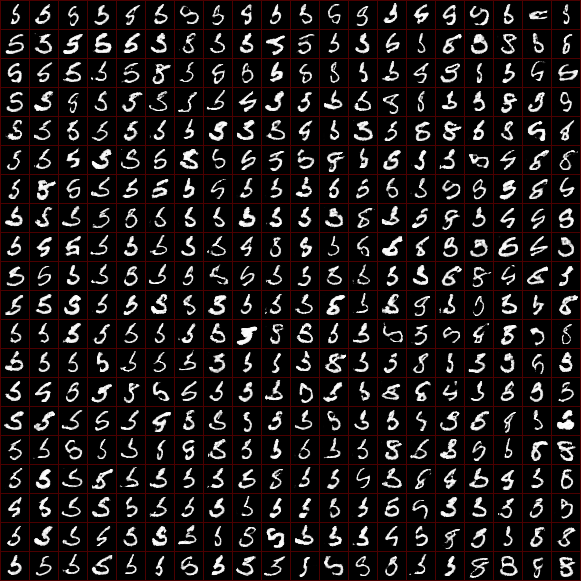

In [7]:
#### CLASS = 1
p=preds[:, 5]
print(p.min(), p.max(),preds.shape)
img = X[np.argsort(p)[::-1]]
print(np.argsort(p)[::-1])
#print(y[np.argsort(p)][::-1])
#img = img[ (p[np.argsort(p)[::-1]])>0.5 ]
img = disp_grid(img[0:400], border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/out.png', img)
Image('imgs/out.png')

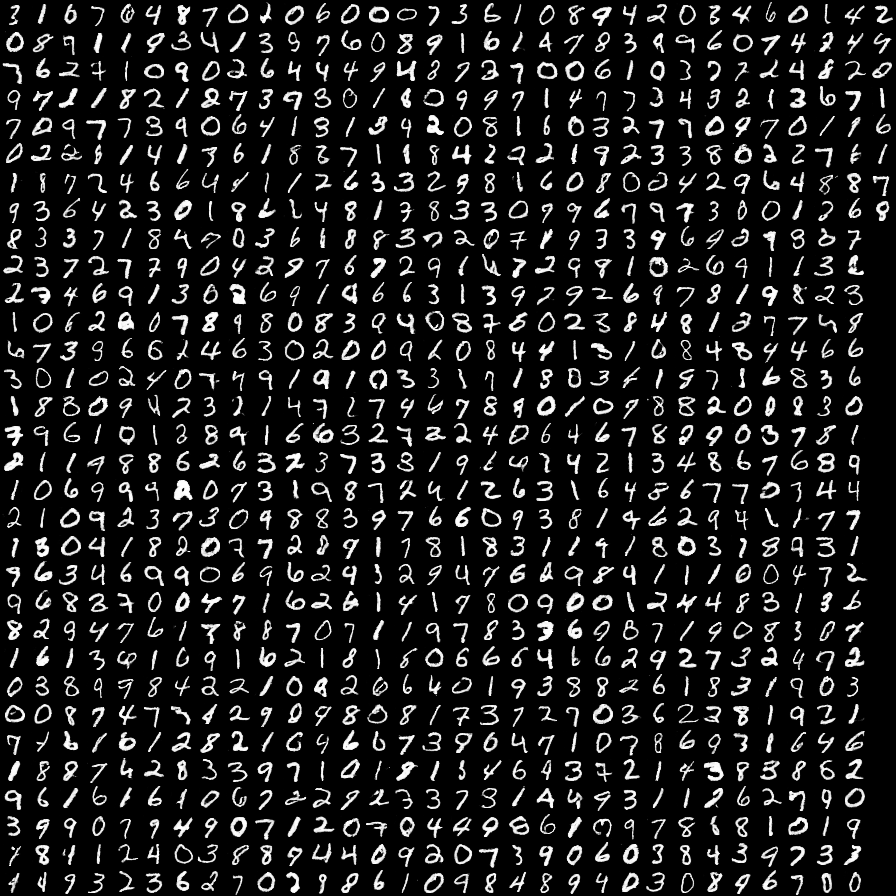

In [36]:
imsave('imgs/out.png', disp_grid(X[0:1000]))
Image('imgs/out.png')

In [40]:
real = Xreal[yreal==5]
points_real = real.reshape((real.shape[0], -1))
fake = X[np.argsort(p)[::-1]][0:100]
#fake = Xreal[yreal==5][0:100]
#fake = X[np.argsort(p)[::-1]][0:100]
#points_fake = fake.reshape((fake.shape[0], -1))

In [41]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=30)
nn.fit(points_real)
dist, indices = nn.kneighbors(points_fake)

(100, 30)


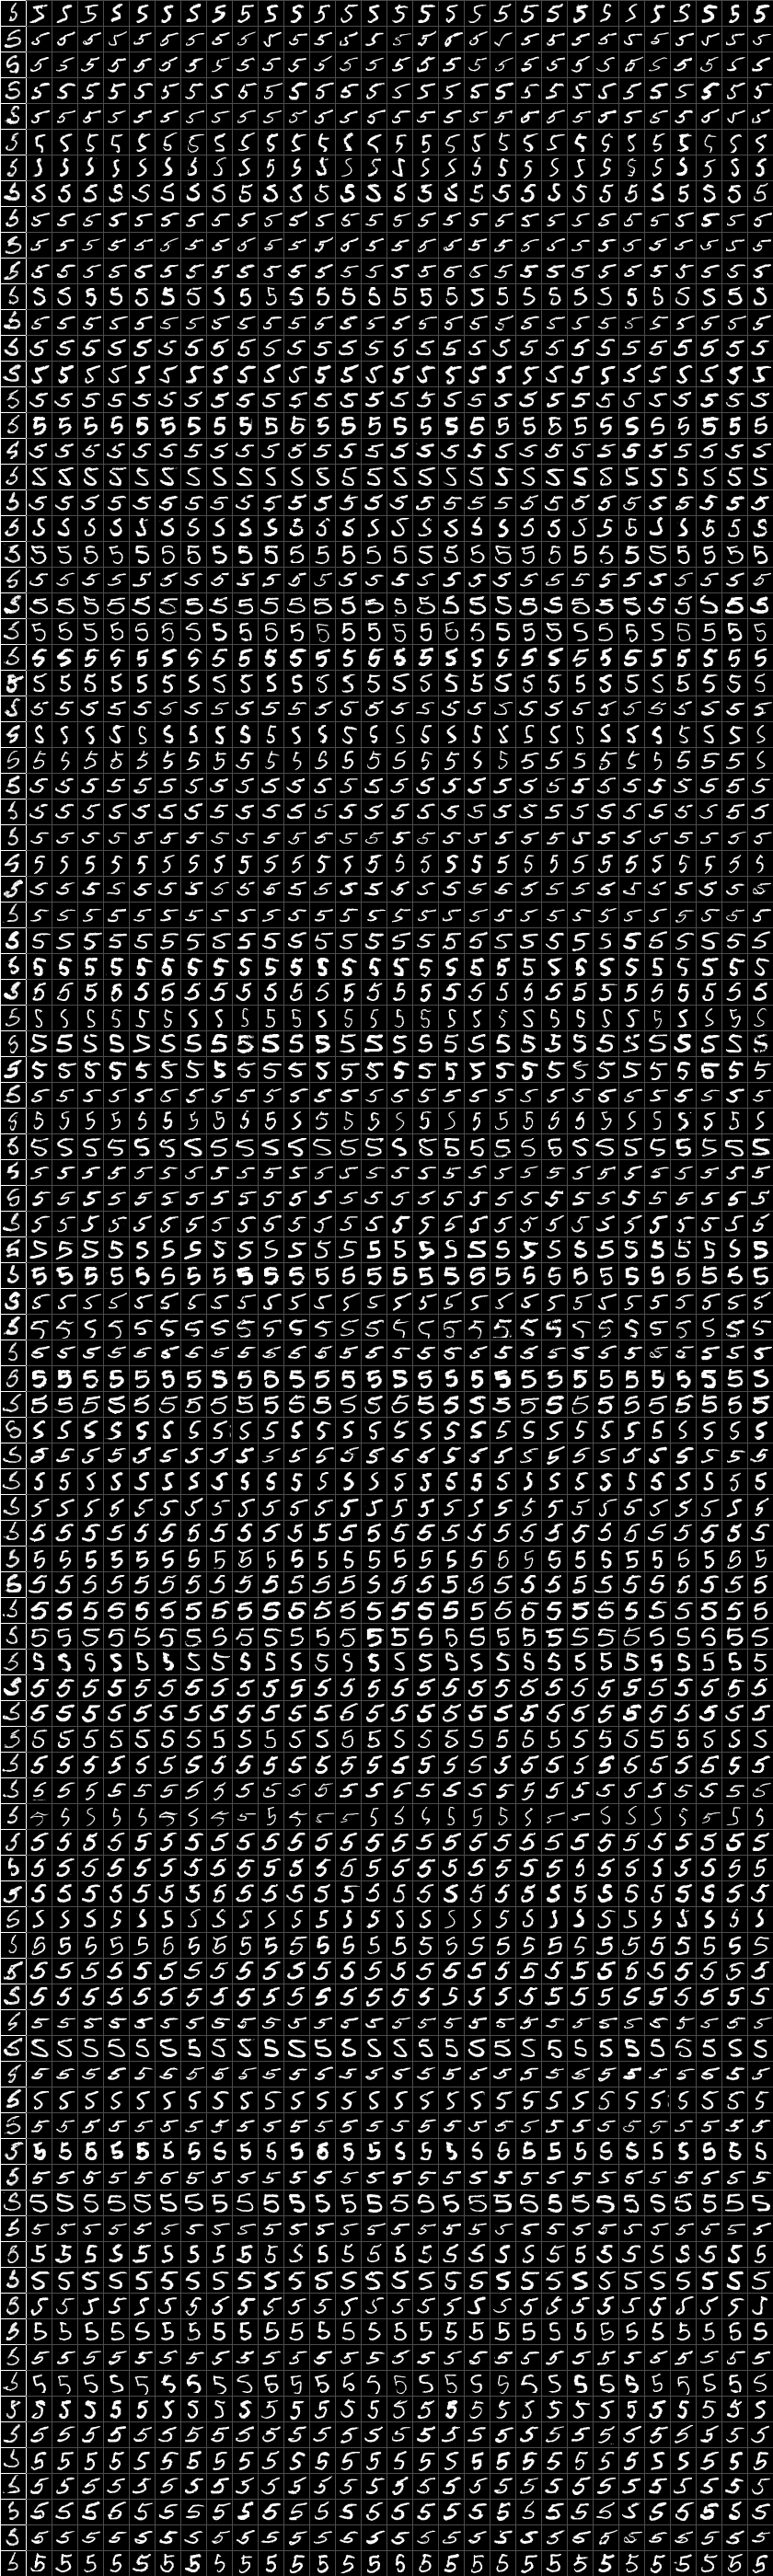

In [42]:
neighb = indices[:]
print(indices.shape)
h=28
w=28
c=1
img = np.zeros((h*indices.shape[0], w*indices.shape[1]))
for y in range(indices.shape[0]):
    for x in range(indices.shape[1]):
        img[y*h:y*h+h, x*w:x*w+w] = fake[y] if x== 0 else real[indices[y, x-1]]
        img[y*h:y*h+h, x*w:x*w+1]=0.3 if x>1 else 1
        img[y*h:y*h+1, x*w:x*w+w+1]=0.3 if x>0 else 1
imsave('imgs/neigh.png', img)
Image('imgs/neigh.png')

In [43]:
def sample():
    rng = np.random
    pt = dict(
        n_components=2,
        perplexity=rng.choice((2, 5, 10, 30, 50, 100)),
        early_exaggeration=rng.randint(1, 10),
        learning_rate=rng.randint(100, 1000), 
        n_iter=5000,
        n_iter_without_progress=500, 
        min_grad_norm=0, 
        metric='euclidean', 
        init=rng.choice(('pca', 'random')),
        verbose=0, 
        random_state=None,
        method='barnes_hut', 
        angle=0.5
    )
    return pt

def run(pt):
    points_ = points.reshape((points.shape[0], -1))
    return TSNE(**pt).fit(points_)

jobs = [sample() for _ in range(100)]
models = Parallel(n_jobs=10, verbose=1)(delayed(run)(j) for j in jobs)
kl = map(lambda m:m.kl_divergence_, models)

JoblibNameError: JoblibNameError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f6c06775230, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/mchert...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f6c06775230, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/mchert...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    648 
    649         If a global instance already exists, this reinitializes and starts it
    650         """
    651         app = cls.instance(**kwargs)
    652         app.initialize(argv)
--> 653         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    654 
    655 #-----------------------------------------------------------------------------
    656 # utility functions, for convenience
    657 #-----------------------------------------------------------------------------

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    400         
    401         if self.poller is not None:
    402             self.poller.start()
    403         self.kernel.start()
    404         try:
--> 405             ioloop.IOLoop.instance().start()
    406         except KeyboardInterrupt:
    407             pass
    408 
    409 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def sample():\n    rng = np.random\n    pt = dict(...jobs)\nkl = map(lambda m:m.kl_divergence_, models)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-10-28T22:01:27.325009', 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'session': 'FF887FEF3A0948108DC51DC36DD1177A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['FF887FEF3A0948108DC51DC36DD1177A']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'def sample():\n    rng = np.random\n    pt = dict(...jobs)\nkl = map(lambda m:m.kl_divergence_, models)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-10-28T22:01:27.325009', 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'session': 'FF887FEF3A0948108DC51DC36DD1177A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['FF887FEF3A0948108DC51DC36DD1177A'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def sample():\n    rng = np.random\n    pt = dict(...jobs)\nkl = map(lambda m:m.kl_divergence_, models)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-10-28T22:01:27.325009', 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'session': 'FF887FEF3A0948108DC51DC36DD1177A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9D988BDA133A445CABCEC83584E66997', 'msg_type': 'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"def sample():\n    rng = np.random\n    pt = d...bs)\nkl = map(lambda m:m.kl_divergence_, models)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"def sample():\n    rng = np.random\n    pt = d...bs)\nkl = map(lambda m:m.kl_divergence_, models)"
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"def sample():\n    rng = np.random\n    pt = d...bs)\nkl = map(lambda m:m.kl_divergence_, models)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.FunctionDef object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-43-388e01b61025>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f6b781a1f90, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f6b78220d30, file "<ipython-input-43-388e01b61025>", line 25>
        result = <ExecutionResult object at 7f6b781a1f90, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f6b78220d30, file "<ipython-input-43-388e01b61025>", line 25>, result=<ExecutionResult object at 7f6b781a1f90, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f6b78220d30, file "<ipython-input-43-388e01b61025>", line 25>
        self.user_global_ns = {'Image': <class 'IPython.core.display.Image'>, 'In': ['', u'get_ipython().magic(u\'matplotlib inline\')\ni...ext\n    img_ = disp_grid(img_)\n    return img_', u"db = load_db()\njobs = db.jobs_with(state=SUCC...results/{}/csv/stats.csv'.format(s)) for s in S}", u"model_folder = '../tools/models/external/mnist...weights(os.path.join(model_folder, 'model.pkl'))", u"X = joblib.load('../../external/dcgan_code/mnist/models/uncond_dcgan/200_gen.npz')", u'batch_size = 1024\npreds = []\nfor i in range(...h_size]))\npreds = np.concatenate(preds, axis=0)', u"plt.imshow(X[72429,0], cmap='gray')", u"#### CLASS = 1\np=preds[:, 5]\nprint(p.min(), ...save('imgs/out.png', img)\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[0:1000]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:72429+100]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:72429+1000]))\nImage('imgs/out.png')", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u"def load_data():\n    from datakit.mnist impor...eal, yreal, _ = load_data()\nX = Xreal[yreal!=5]", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u'from sklearn.neighbors import NearestNeighbors...eal)\ndist, indices = nn.kneighbors(points_fake)', u"neighb = indices[:]\nprint(indices.shape)\nh=2...('imgs/neigh.png', img)\nImage('imgs/neigh.png')", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u'from sklearn.neighbors import NearestNeighbors...eal)\ndist, indices = nn.kneighbors(points_fake)', u"neighb = indices[:]\nprint(indices.shape)\nh=2...('imgs/neigh.png', img)\nImage('imgs/neigh.png')", ...], 'NearestNeighbors': <class 'sklearn.neighbors.unsupervised.NearestNeighbors'>, 'Out': {6: <matplotlib.image.AxesImage object>, 7: <IPython.core.display.Image object>, 8: <IPython.core.display.Image object>, 10: <IPython.core.display.Image object>, 11: <IPython.core.display.Image object>, 19: <IPython.core.display.Image object>, 23: <IPython.core.display.Image object>, 24: <IPython.core.display.Image object>, 31: <IPython.core.display.Image object>, 33: <IPython.core.display.Image object>, ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'S': [u'23103a127e5214543edfbdab16eda380', u'4bf72d48b6b4e1e4631e1bd4cf2b7ba6', u'455763891961cfa35a0cf453f9a85f8a', u'b93f6b67269ca68db85c9a1aeeda96ae', u'ed92cb5d17b44370636c09ac75646beb', u'047f7eda2633dfbaf3007a20faec148a', u'7e9fb6f5dcfaf3a6a1c62d7e14c9a804', u'92835611bbb0909760ac6c3be70031e3', u'9304a9a2cea22195468e47bc4d1981a5', u'3f8e24483f7e8cb7f55abe2dfa6384d3', u'71a4156d5abb09b8b562868a26a3349f', u'49d4462c14a985a5738c03f402d7a1ee', u'ef00284c99c11e6cb95a6a39e8d924f3', u'528c0c27e55b0005a49a98a86230550a', u'1d7b2ff94e972dd1a0d3266f46fa2f4c', u'fedc34c2dbdaed1dd44acbabdc5ce605', u'fc5a5994a338af5337c1ca001681b756', u'1c245c625f61a98e15d6f86c55adbe01', u'6e6859c0110fb1ad20a9404caf7bc5fd', u'd58136b03ff29eaf7ba9f7801447b867', ...], 'SUCCESS': 'success', 'X': array([[[[  1.61650691e-28,   7.47235427e-25,   ...1470309e-16,   3.57437718e-10]]]], dtype=float32), 'Xreal': array([[[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
 ...         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]]]), ...}
        self.user_ns = {'Image': <class 'IPython.core.display.Image'>, 'In': ['', u'get_ipython().magic(u\'matplotlib inline\')\ni...ext\n    img_ = disp_grid(img_)\n    return img_', u"db = load_db()\njobs = db.jobs_with(state=SUCC...results/{}/csv/stats.csv'.format(s)) for s in S}", u"model_folder = '../tools/models/external/mnist...weights(os.path.join(model_folder, 'model.pkl'))", u"X = joblib.load('../../external/dcgan_code/mnist/models/uncond_dcgan/200_gen.npz')", u'batch_size = 1024\npreds = []\nfor i in range(...h_size]))\npreds = np.concatenate(preds, axis=0)', u"plt.imshow(X[72429,0], cmap='gray')", u"#### CLASS = 1\np=preds[:, 5]\nprint(p.min(), ...save('imgs/out.png', img)\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[0:1000]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:72429+100]))\nImage('imgs/out.png')", u"imsave('imgs/out.png', disp_grid(X[72429:72429+1000]))\nImage('imgs/out.png')", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u"def load_data():\n    from datakit.mnist impor...eal, yreal, _ = load_data()\nX = Xreal[yreal!=5]", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u'from sklearn.neighbors import NearestNeighbors...eal)\ndist, indices = nn.kneighbors(points_fake)', u"neighb = indices[:]\nprint(indices.shape)\nh=2...('imgs/neigh.png', img)\nImage('imgs/neigh.png')", u'real = Xreal[yreal!=5]\npoints_real = real.res...npoints_fake = fake.reshape((fake.shape[0], -1))', u'from sklearn.neighbors import NearestNeighbors...eal)\ndist, indices = nn.kneighbors(points_fake)', u"neighb = indices[:]\nprint(indices.shape)\nh=2...('imgs/neigh.png', img)\nImage('imgs/neigh.png')", ...], 'NearestNeighbors': <class 'sklearn.neighbors.unsupervised.NearestNeighbors'>, 'Out': {6: <matplotlib.image.AxesImage object>, 7: <IPython.core.display.Image object>, 8: <IPython.core.display.Image object>, 10: <IPython.core.display.Image object>, 11: <IPython.core.display.Image object>, 19: <IPython.core.display.Image object>, 23: <IPython.core.display.Image object>, 24: <IPython.core.display.Image object>, 31: <IPython.core.display.Image object>, 33: <IPython.core.display.Image object>, ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'S': [u'23103a127e5214543edfbdab16eda380', u'4bf72d48b6b4e1e4631e1bd4cf2b7ba6', u'455763891961cfa35a0cf453f9a85f8a', u'b93f6b67269ca68db85c9a1aeeda96ae', u'ed92cb5d17b44370636c09ac75646beb', u'047f7eda2633dfbaf3007a20faec148a', u'7e9fb6f5dcfaf3a6a1c62d7e14c9a804', u'92835611bbb0909760ac6c3be70031e3', u'9304a9a2cea22195468e47bc4d1981a5', u'3f8e24483f7e8cb7f55abe2dfa6384d3', u'71a4156d5abb09b8b562868a26a3349f', u'49d4462c14a985a5738c03f402d7a1ee', u'ef00284c99c11e6cb95a6a39e8d924f3', u'528c0c27e55b0005a49a98a86230550a', u'1d7b2ff94e972dd1a0d3266f46fa2f4c', u'fedc34c2dbdaed1dd44acbabdc5ce605', u'fc5a5994a338af5337c1ca001681b756', u'1c245c625f61a98e15d6f86c55adbe01', u'6e6859c0110fb1ad20a9404caf7bc5fd', u'd58136b03ff29eaf7ba9f7801447b867', ...], 'SUCCESS': 'success', 'X': array([[[[  1.61650691e-28,   7.47235427e-25,   ...1470309e-16,   3.57437718e-10]]]], dtype=float32), 'Xreal': array([[[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
 ...         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]]]), ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/mcherti/work/code/feature_generation/ipynb/<ipython-input-43-388e01b61025> in <module>()
     20 def run(pt):
     21     points_ = points.reshape((points.shape[0], -1))
     22     return TSNE(**pt).fit(points_)
     23 
     24 jobs = [sample() for _ in range(100)]
---> 25 models = Parallel(n_jobs=10, verbose=1)(delayed(run)(j) for j in jobs)
     26 kl = map(lambda m:m.kl_divergence_, models)
     27 
     28 
     29 

...........................................................................
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=10), iterable=<generator object <genexpr>>)
    655             if pre_dispatch == "all" or n_jobs == 1:
    656                 # The iterable was consumed all at once by the above for loop.
    657                 # No need to wait for async callbacks to trigger to
    658                 # consumption.
    659                 self._iterating = False
--> 660             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=10)>
    661             # Make sure that we get a last message telling us we are done
    662             elapsed_time = time.time() - self._start_time
    663             self._print('Done %3i out of %3i | elapsed: %s finished',
    664                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    NameError                                          Fri Oct 28 22:01:27 2016
PID: 2070Python 2.7.12: /home/mcherti/miniconda/envs/databoard-env/bin/python
...........................................................................
/home/mcherti/work/code/feature_generation/ipynb/<ipython-input-43-388e01b61025> in run(pt={'angle': 0.5, 'early_exaggeration': 6, 'init': 'pca', 'learning_rate': 336, 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 0, 'n_components': 2, 'n_iter': 5000, 'n_iter_without_progress': 500, ...})
     16         angle=0.5
     17     )
     18     return pt
     19 
     20 def run(pt):
---> 21     points_ = points.reshape((points.shape[0], -1))
     22     return TSNE(**pt).fit(points_)
     23 
     24 jobs = [sample() for _ in range(100)]
     25 models = Parallel(n_jobs=10, verbose=1)(delayed(run)(j) for j in jobs)

NameError: global name 'points' is not defined
___________________________________________________________________________

In [ ]:
from collections import defaultdict
perplexities = defaultdict(list)
for m in models:
    perplexities[m.perplexity].append(m)
fig, ax = plt.subplots(1, len(perplexities), figsize=(25, 5))
i = 0
for perp in sorted(perplexities.keys()):
    tsne = min(perplexities.get(perp), key=lambda model:model.kl_divergence_)
    embedding = tsne.embedding_
    ax[i].scatter(embedding[:, 0], embedding[:, 1])
    ax[i].set_title('perplexity {}'.format(perp))
    i += 1
plt.show()

In [ ]:
tsne = min(perplexities[10], key=lambda m:m.kl_divergence_)
embedding = tsne.embedding_

In [ ]:
from tools.viz.image_scatter import image_scatter
pts = points.reshape((points.shape[0], 28, 28)).copy()
pts = pts[:, :, :, None] * np.ones((1, 1, 1, 3))
pts[0:10, :, :, 1:]=0
img = image_scatter(embedding, pts, 20, 500)
imsave('imgs/out.png', img)
Image('imgs/out.png')

## checking stats of jobs

In [ ]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset83')
S = [j['summary'] for j in jobs]

In [ ]:
jobs_gen = to_generation(jobs, db=db)

In [ ]:
field = 'stats.out_of_the_box_classification.m2.objectness'
indices = np.arange(len(jobs))
for i in range(len(jobs_gen)):
    j = jobs_gen[i]
    v = db.get_value(j, field, if_not_found=None)
    if not v:print('Misssing generation jobs from training job : {}, skip it.'.format(jobs[i]['summary']))

In [ ]:
def compute(j):
    if not j:return np.nan
    data = joblib.load("../jobs/results/{}/images.npz".format(j['summary']))
    data = data[:, -1]
    y = model.predict(data)
    score = compute_objectness(y)
    print(score)
    return score

In [ ]:
import shutil
indices = np.arange(len(jobs))
#objectness = map(lambda j:db.get_value(j, field, if_not_found=np.nan), jobs_gen)
objectness = map(compute, jobs_gen)
objectness = np.array(objectness)
indices = filter(lambda ind:not np.isnan(objectness[ind]), indices)
indices = sorted(indices, key=lambda i:objectness[i])
indices = indices[::-1]
images = ['../exported_data/figs/generated/jobset{:05d}/{}.png'.format(int(jobs[i]['where'][6:]), jobs_gen[i]['summary']) 
          for i in indices]
print(jobs_gen[indices[1]]['summary'])
for i in range(len(images)):
    print(jobs_gen[indices[i]]['summary'])
    shutil.copy(images[i], 'export/{:05d}.png'.format(i))
    #display(Image(images[i]), width=100, height=100)

## objectness score

In [ ]:
model_folder = '../tools/models/mnist/m2'
#model_folder = '../../nnbench/out/feature_generation/12457_vs_fake_jobset76/'
#model_folder = '../tools/models/mnist/m2'
arch = (open(os.path.join(model_folder, 'model.json'))).read()
#arch = arch.replace('softmax', 'linear')
model = model_from_json(arch)
model.load_weights(os.path.join(model_folder, 'model.h5'))

In [ ]:
hf = h5py.File('../exported_data/datasets/jobset83.hdf5')
X = hf['X']
nb = hf.attrs['nb']
X = X[0:nb]
X[np.isnan(X)] = 0
X = X[X.sum(axis=(1, 2, 3)) > 0]

"""
data = joblib.load('../jobs/results/1e47d7dea091c42c90b71ec06dee4f4d/images.npz')
X = data[:, -1]
"""


"""
from datakit.mnist import load
data = load(which='test')
X = data['test']['X']
y = data['test']['y']
X = X / 255.
X=X[0:1000]
print(X.min(), X.max())
print(X.shape)
"""

In [ ]:
from tools.common import compute_objectness

def compute_objectness_renyi(v, alpha=2):
    v = np.array(v)
    marginal = v.mean(axis=0)
    score = (1/(alpha-1)) * np.log(((v ** alpha) / marginal ** (alpha - 1)).sum(axis=1))
    score = score.mean()
    score = np.exp(score)
    score = float(score)
    return score


def compute_sample_objectness_renyi(v, alpha=2):
    score = (1/(alpha-1)) * np.log((v**alpha).sum(axis=1))
    return score

preds = model.predict(X)
#preds = (preds - preds.min(axis=0, keepdims=True)) / (preds.max(axis=0, keepdims=True) - preds.min(axis=0, keepdims=True))
#objectness = compute_sample_objectness(preds)
objectness = compute_sample_objectness_renyi(preds,alpha=1.1)

In [ ]:
ind = np.argsort(objectness)[::-1]
#ind =ordering
X_sorted = X[ind]
preds_sorted = preds[ind]
objectness_sorted = objectness[ind]

In [ ]:
sample = np.arange(len(X))
np.random.shuffle(sample)
sample = sample[0:100]
objectness_sampled = objectness[sample]
X_sampled = X[sample]
preds_sampled = preds[sample]
X_sampled = X_sampled[np.argsort(objectness_sampled)[::-1]]
preds_sampled = preds_sampled[np.argsort(objectness_sampled)[::-1]]

In [ ]:
im = disp_grid_with_pred(X_sorted[0::1000], preds_sorted[0::1000])
imsave('imgs/out.png', im)
Image('imgs/out.png', width=800, height=800)

In [ ]:
a=1